<h1> Spiking Neural Networks </h1>

<h3> Introduction </h3>

Recent advancements in artificial intelligence are largely attributed to neural networks (NNs), which are machine learning models designed to recognize patterns and make predictions. Artificial neural networks are composed of multiple layers, each containing numerous "neurons." Although inspired by biological neural networks, these models remain fundamentally distinct from their biological counterparts. While research on traditional NNs continues to progress, spiking neural networks (SNNs) have begun to attract increasing attention. SNNs offer a novel approach to data processing by aiming to replicate the dynamic behavior and energy efficiency observed in biological neurons.

As the field of machine learning advances, it is important to consider unconventional computational methods, such as SNNs and neuromorphic computing in general. This approach to hardware and computation seeks to achieve greater efficiency and brain-like processing capabilities.

<h3> How do Spiking Neural Networks work </h3>

SNNs are distinct from traditional artificial neural networks due to their internal temporal states, which make the timing of input data critical for neuron activation. For example, if an input to neuron A decays before neuron B spikes, neuron C—connected to both A and B—will be less likely to spike. Spikes are discrete events that emulate the action potentials of biological neurons. The presence of temporal states enables SNNs to process information asynchronously, in contrast to the synchronous layer-wise processing of artificial neural networks, which typically operate in either a forward or backward (backpropagation) direction. In SNNs, neurons in different layers may spike simultaneously, reflecting the asynchronous data processing observed in the brain and contributing to its energy efficiency. However, this asynchronous processing prevents SNNs from utilizing learning algorithms such as backpropagation.[[6]](#6). 

<h4> Non-differentiable nature of spiking functions </h4>

Each spike in an SNN is a variation of a unit step function, whose derivative is the Dirac delta function (recall DSP course). Despite this, spikes are considered non-differentiable because the Dirac delta produces a binary output: zero for all values except at the spike, where it approaches infinity [[8]](#8). Weight optimization requires continuous values to indicate the necessary adjustment, making the binary nature of spikes incompatible with gradient descent [[4,5]](#4). Nevertheless, alternative approaches exist to address this limitation. 

<h4>Backpropagation for SNNs</h4>

The surrogate gradient (SG) method introduces an alternative approach to gradient-based learning in SNNs. This technique replaces the derivative of the non-differentiable spike function with the derivative of a smooth, differentiable approximation during backpropagation. For a comprehensive mathematical explanation of SG, see Surrogate Gradient Learning in Spiking Neural Networks by Neftci et al.

<h4>Implicit gradient descent for SNNs</h4>
Contrastive Hebbian learning (CHL) serves as an alternative to backpropagation. CHL divides learning into two phases: a free phase and a clamped phase. In the free phase, the network input is fixed while the output varies and converges to equilibrium, after which a standard Hebbian weight update is applied. In the clamped phase, the network output is fixed at a desired value, and the system converges to a new equilibrium. Weights are then updated again, this time using a negative anti-Hebbian update rule.

Equilibrium propagation (EP) is a more refined form of CHL. It also consists of two phases; the free phase, in the case of EP, is 

Spike-timing-dependent plasticity

<h3>Brian2</h3>
Simulating Biological Neural Networks





In [ ]:
from brian2 import *

# This function prevents mixing brian2 objects created before initialization. Its good practice to include it.
start_scope()

N = 25                  # 1 Number of neurons 
tau = 10*ms             # 2 Membrane reaction time
vr = -70*mV             # 3 Reset potential
vt0 = -55*mV            # 4 Resting state
delta_vt0 = 5*mV        # 5 Threshold jump
tau_t = 10*ms           # 6 Threshold adaptation
sigma = 0.5*(vt0-vr)    # 7 Noise
v_drive = 2*(vt0-vr)    # 8 The driving input
duration = 100*ms       # 9 Duration of the simulation 

# Neurons' dynamics 
eqs = """
dv/dt = (delta_vt0 + vr - v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
"""

# Reset behaviour
reset = """
v = vr
vt += delta_vt0
"""


Lets go over all the variables that we initialized. 

1. First we have N, that is the number of neurons that we are going to stimulate in our group.
2. Tau represents the time that the membrane voltage of our neuron will react to input.
3. Vr represents the depression of a neuron after an action potential happens
4. Vt0 is the resting state of the neuron
5. Delta rises the threshold after spike. 
6. Tau_t tells us how fast will the threshold return to normal after a spike.
7. Sigma is a noise that we will introduce to create slight fluctuations in voltage of neurons
8. V_drive is the current that will push all neurons towards firing
9. This is simple the duration of our simulation

Equations

Membrane potential: 

$$\frac{dv}{dt} = \frac{v_{drive} + v_r - v}{\tau} + \frac{\sigma*x_i}{\sqrt{\tau}}$$


Firstly, so called leaky integrator [[12]](#12) $$\frac{v_{drive} + v_r - v}{\tau}$$ This function pulls the voltage of a neuron towards a spike, tau controls how fast the voltage changes.

Secondly the noise $$\frac{\sigma*x_i}{\sqrt{\tau}}$$ This introduces random noise to neurons. x_i is the Gaussian white noise, it makes the noise random.


Threshold dynamics:
$$\frac{dv_t}{dt} = \frac{(v_t0-v_t)}{\tau_t} $$

This slowly brings back the voltage of a neuron back to vt0 (resting state) after a non-spike change.

Reset:

After a spike the voltage will go to vr and the vt (threshold) will increase by delta_vt0.


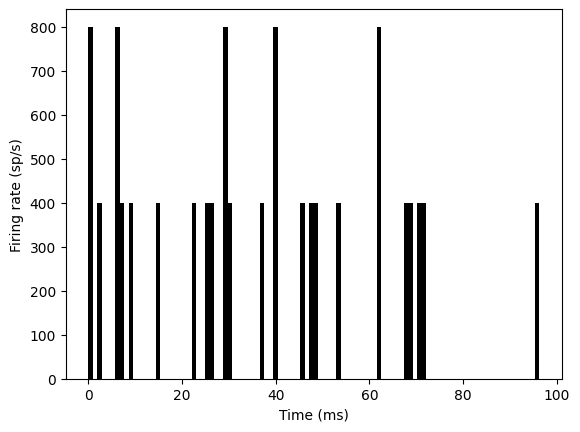

In [156]:
neurons = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')

neurons.v = 'rand()*(vt0-vr)+vr'
neurons.vt = vt0

S = Synapses(neurons, neurons)
S.connect(condition="i!=j", p=0.15)

spike_monitor = SpikeMonitor(neurons)
voltage_monitor = StateMonitor(neurons, 'v', record=[0, 1, 2, 3])
M = StateMonitor(neurons, 'v', record=True)

run(duration)

spike_trains = spike_monitor.spike_trains()

#NOTE graph taken from official Brian2 guide -- https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html
_ = hist(spike_monitor.t/ms, 100, histtype='stepfilled', facecolor='k', weights=list(ones(len(spike_monitor))/(N*defaultclock.dt)))
xlabel('Time (ms)')
ylabel('Firing rate (sp/s)');

In this cell we have actually run the simulation. First we created neuron group with variables that were defined above. Next two lines changes the initial values of the NeuronGroup object, we set initial membrane voltage to a random value between vr and vt0. We also set the spike threshold vt to vt0. 

We also created synapses, once again it is pretty straightforward, just declare Synapses object and call connection() with a condition and probability. 
After random synapses were created, we created a few objects like SpikeMonitor or StateMonitor. They are here just for plotting, we don't need to concern ourselves with it. 
All thats left to do is to run the simulation for a specified amount of time. 
I took and created some plots. Plots in this cell and the next cell were taken from the Brian2 official guide. I created the last plot. 
I encourage you to play around with the initial variables, and equations to see how the behaviour of the neuron group changes! 

Text(0, 0.5, 'Target neuron index')

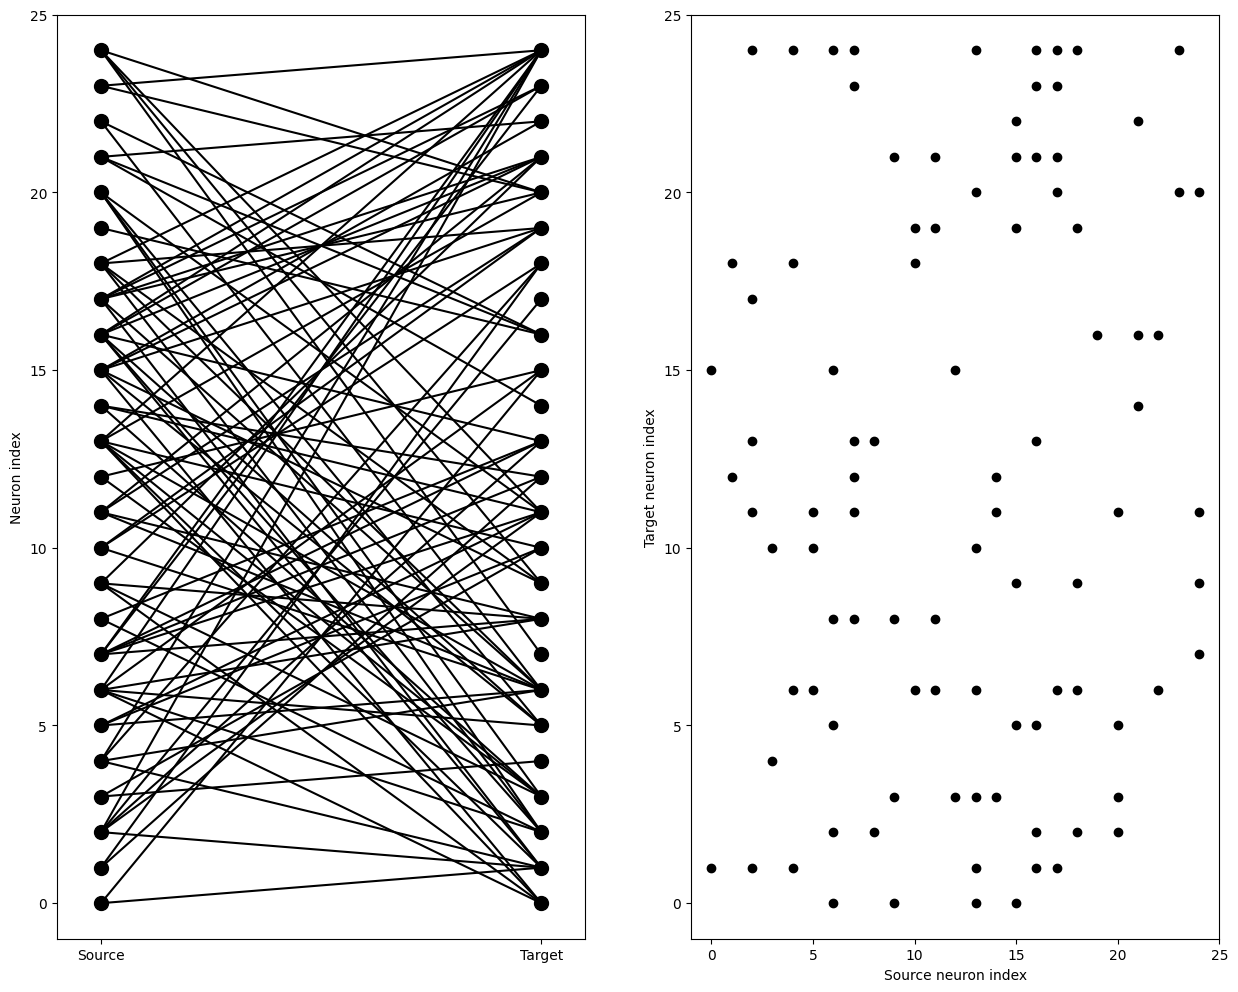

In [157]:
#NOTE graph taken from https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html
Ns = len(S.source)
Nt = len(S.target)
figure(figsize=(15, 12))
subplot(121)
plot(zeros(Ns), arange(Ns), 'ok', ms=10)
plot(ones(Nt), arange(Nt), 'ok', ms=10)
for i, j in zip(S.i, S.j):
    plot([0, 1], [i, j], '-k')
xticks([0, 1], ['Source', 'Target'])
ylabel('Neuron index')
xlim(-0.1, 1.1)
ylim(-1, max(Ns, Nt))
subplot(122)
plot(S.i, S.j, 'ok')
xlim(-1, Ns)
ylim(-1, Nt)
xlabel('Source neuron index')
ylabel('Target neuron index')



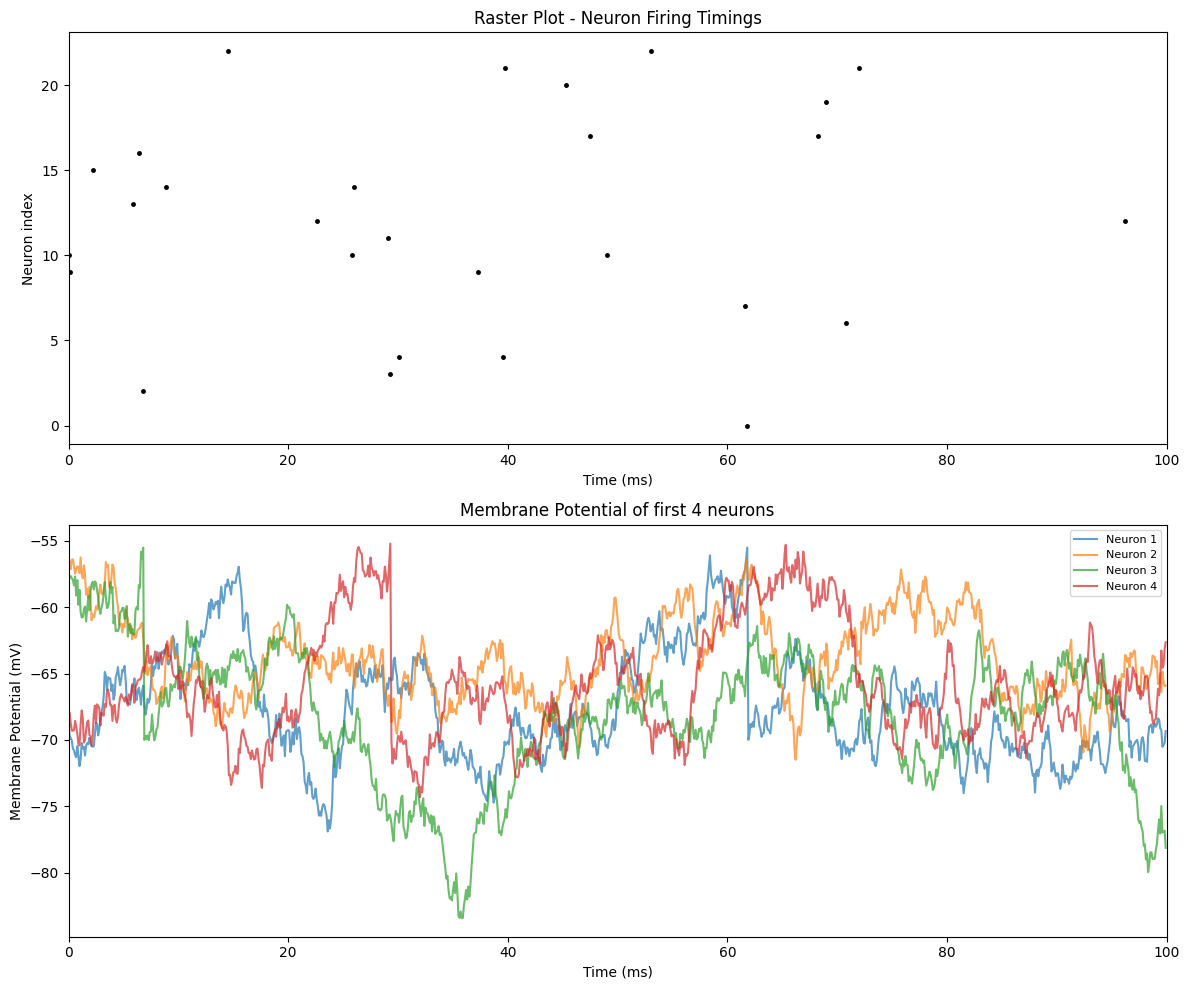

<spikemonitor.t: array([ 0. ,  0.1,  2.2,  5.9,  6.4,  6.8,  8.9, 14.5, 22.6, 25.8, 26. ,
       29.1, 29.3, 30.1, 37.3, 39.6, 39.7, 45.3, 47.5, 49. , 53. , 61.6,
       61.8, 68.2, 69. , 70.8, 72. , 96.2]) * msecond>


In [ ]:
# Some more visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# spike timings
axes[0].plot(spike_monitor.t/ms, spike_monitor.i, '.k', markersize=5)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Neuron index')
axes[0].set_title('Raster Plot - Neuron Firing Timings')
axes[0].set_xlim(0, duration/ms)

#  Membrane potential
for i in range(4):
    axes[1].plot(voltage_monitor.t/ms, voltage_monitor.v[i]/mV, 
                    label=f'Neuron {i+1}', alpha=0.7)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Membrane Potential (mV)')
axes[1].set_title('Membrane Potential of first 4 neurons')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].set_xlim(0, duration/ms)

plt.tight_layout()
plt.show()

print(spike_monitor.t)

In [ ]:
# NOTE
from midiutil import MIDIFile
import pygame
import numpy as np

def avgRatePitch(neural_data, time_window, sampling_interval, 
                    pitch_range=(60, 84), rate_range=None):
    
    start_time, end_time = time_window
    
    # Create time bins
    time_points = np.arange(start_time, end_time, sampling_interval)
    n_samples = len(time_points)
    
    # Calculate firing rates for each time bin
    firing_rates = np.zeros(n_samples)
    
    for i, t in enumerate(time_points):
        bin_start = t
        bin_end = t + sampling_interval
        
        # Count spikes in this time window for all neurons
        total_spikes = 0
        for neuron_spikes in neural_data:
            # Count spikes that fall within this time bin
            spikes_in_bin = np.sum((neuron_spikes >= bin_start) & 
                                    (neuron_spikes < bin_end))
            total_spikes += spikes_in_bin
        
        # Calculate average firing rate (spikes per second per neuron)
        n_neurons = len(neural_data)
        firing_rates[i] = total_spikes / (n_neurons * sampling_interval)
    
    # Determine rate range for normalization
    if rate_range is None:
        min_rate = np.min(firing_rates)
        max_rate = np.max(firing_rates)
    else:
        min_rate, max_rate = rate_range
    
    # Map firing rates to pitch range
    min_pitch, max_pitch = pitch_range
    
    # Normalize and map to pitch
    if max_rate > min_rate:
        normalized_rates = (firing_rates - min_rate) / (max_rate - min_rate)
        pitches = min_pitch + normalized_rates * (max_pitch - min_pitch)
    else:
        # If all rates are the same, use middle pitch
        pitches = np.full(n_samples, (min_pitch + max_pitch) / 2)
    
    # Round to nearest MIDI note
    pitches = np.round(pitches).astype(int)
    
    # Clip to ensure within range
    pitches = np.clip(pitches, min_pitch, max_pitch)
    
    return pitches, time_points



def make_music(pitches, time_points, tempo=120):
    midi = MIDIFile(1)
    track = 0
    channel = 0
    volume = 100
    
    midi.addTempo(track, 0, tempo)
    
    # Adding notes
    for i, pitch in enumerate(pitches):
        if i < len(pitches) - 1:
            duration = time_points[i+1] - time_points[i]
        else:
            duration = time_points[1] - time_points[0]
        
        midi.addNote(track, channel, int(pitch), time_points[i], 
                    duration, volume)
    
    # Save MIDI file
    with open("neural_sonification.mid", "wb") as output_file:
        midi.writeFile(output_file)
        

In [ ]:
"""
    Same as before, but we will make our simulations longer and have more neurons. 
"""

start_scope()

neurons1 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
neurons2 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
neurons3 = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')

volt_ini = 'rand()*(vt0-vr)+vr'

neurons1.v, neurons2.v, neurons3.v  = volt_ini, volt_ini, volt_ini
neurons1.vt, neurons2.vt, neurons3.vt = vt0, vt0, (vt0 + vt0*0.001)

S1 = Synapses(neurons1, neurons2)
S2 = Synapses(neurons2, neurons3)

S1.connect(p=0.15)
S2.connect(p=0.1)

spike_monitor1 = SpikeMonitor(neurons1)
spike_monitor2 = SpikeMonitor(neurons2)
spike_monitor3 = SpikeMonitor(neurons3)

run(1000*ms)

# Take all spikes and flatten it, make it float
all_spikes = [(spike_monitor1.t / ms).astype(float)/100, 
                (spike_monitor2.t / ms)/100, 
                (spike_monitor3.t / ms)/100]

pitches, time_points = avgRatePitch(
        neural_data=all_spikes,
        time_window=(0, 10),
        sampling_interval=0.2
    )

make_music(pitches, time_points)

Lastly I have prepared some real life data, this data has been taken from chimps. There are few neurons, to be precise neuronal clusters. 

In [160]:
from scipy.io import loadmat

""" This file is sort of messy may change later  """

data_files = [
    "neurons/m06cat003spk001a.mat",
    "neurons/m06cat003spk001b.mat",
]

all_spikes = []

for f in data_files:
    data = loadmat(f, simplify_cells=True)
    neuron_data = data['neuron']

    all_spikes.append(neuron_data[:200])  


<h3>snnTorch</h3>

I showcased some simple neuron simulation using Brian2, while it is a good choice for simulating neurons it is not ideal for training SNNs. If you would like to learn how to train actual SNN I recommend this guide by Jason Eshraghian and Fabrizio Ottati from Open Neuromorphic community [[7]](#7). This workshop will teach you all the basics you need to work with a simple SNN using snnTorch.


<h3>Discussion</h3>

While SNNs present us with promising future for computation, we need to keep in mind problems unique to this deep learning model. 
Firstly they do 

[NC-NL](https://nc-nl.nl/) is newly established organization that aims create momentum for a dutch neuromorphic computing innovations. The leading representative is Johan Mentink, Associate Professor at Radboud University.

Bio data taken from [A large neuronal dataset for natural category-based free-gaze visual search in macaques](https://osf.io/sdgkr/overview)

<h3>References:</h3>

<a id='1'>[1]</a> Zhang, J., Zhu, X., Zhou, H. et al. A large neuronal dataset for natural category-based free-gaze visual search in macaques. Sci Data 12, 779 (2025). https://doi.org/10.1038/s41597-025-05130-5

<a id='2'>[2]</a> Chang, Mindy & Wang, Ge & Berger, Jonathan. (2010). Sonification and Visualization of Neural Data. https://www.researchgate.net/publication/265165122_Sonification_and_Visualization_of_Neural_Data

<a id='3'>[3]</a> Fangfang Lee. What is a neural network? https://www.ibm.com/think/topics/neural-networks 

<a id='4'>[4]</a> Neftci, Emre O.; Mostafa, Hesham; Zenke, Friedemann. Surrogate Gradient Learning in Spiking Neural Networks (2019). https://doi.org/10.48550/arXiv.1901.09948

<a id='5'>[5]</a> Sanaz M. Takaghaj; Jack Sampson. Rouser: Robust SNN training using adaptive threshold learning (2024) https://doi.org/10.48550/arXiv.2407.19566

<a id='6'>[6]</a> Sanaz M. Takaghaj; Jack Sampson. To Spike or Not to Spike, that is the Question (2025)	https://doi.org/10.48550/arXiv.2407.19566

<a id='7'>[7]</a> Jason Eshraghian; Fabrizio Ottati Hands-on With SnnTorch (2023) https://open-neuromorphic.org/workshops/hands-on-with-snntorch-jason-eshraghian/

<a id='8'>[8]</a> Dirac delta function https://en.wikipedia.org/wiki/Dirac_delta_function

<a id='9'>[9]</a> Beren Millidge; Yuhang Song; Tommaso Salvatori; Thomas Lukasiewicz; Rafal Bogacz BACKPROPAGATION AT THE INFINITESIMAL INFERENCE LIMIT OF ENERGY-BASED MODELS: UNIFYING PREDICTIVE CODING, EQUILIBRIUM PROPAGATION, AND CONTRASTIVE HEBBIAN LEARNING (2020) https://arxiv.org/pdf/2206.02629

<a id='10'>[10]</a> Benjamin Scellier; Equilibrium Propagation; https://bscellier.github.io/eqprop/eqprop.html

<a id='11'>[11]</a> Leaky integrator https://en.wikipedia.org/wiki/Leaky_integrator